# Sales Prediction Analysis

This notebook implements a real-time sales prediction system using ARIMA models. The system analyzes historical sales data to make predictions about future stock requirements.

## Table of Contents
1. Data Loading and Initial Setup
2. Data Preprocessing
3. Time Series Analysis
4. Model Implementation
5. Visualization and Prediction

## 1. Data Loading and Initial Setup

First, let's import the required libraries and load our dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from datetime import datetime, timedelta
import warnings

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_palette("husl")

In [2]:
# Load the dataset
df = pd.read_csv('online_retail_II.csv')

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())

print("\nSample Data:")
print("-" * 50)
df.head()

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None

Sample Data:
--------------------------------------------------


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 2. Data Preprocessing

Let's clean and prepare our data for analysis.

In [3]:
def preprocess_data(df):
    # Create a copy to avoid modifying original data
    df_cleaned = df.copy()
    
    # Convert InvoiceDate to datetime
    df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])
    
    # Remove any negative quantities and prices
    df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['Price'] > 0)]
    
    # Calculate total amount for each transaction
    df_cleaned['TotalAmount'] = df_cleaned['Quantity'] * df_cleaned['Price']
    
    return df_cleaned

# Apply preprocessing
df_cleaned = preprocess_data(df)

# Display preprocessing results
print("Data shape before cleaning:", df.shape)
print("Data shape after cleaning:", df_cleaned.shape)
print("\nSummary statistics:")
df_cleaned.describe()

Data shape before cleaning: (1067371, 8)
Data shape after cleaning: (1041671, 9)

Summary statistics:


,Quantity,InvoiceDate,Price,Customer ID,TotalAmount
count,1.041671e+06,1041671,1.041671e+06,805549.000000,1.041671e+06
mean,1.096345e+01,2011-01-03 16:31:26.403269376,4.077038e+00,15331.954970,2.013397e+01
min,1.000000e+00,2009-12-01 07:45:00,1.000000e-03,12346.000000,1.000000e-03
25%,1.000000e+00,2010-07-12 10:26:00,1.250000e+00,13982.000000,3.900000e+00
50%,3.000000e+00,2010-12-07 15:33:00,2.100000e+00,15271.000000,9.960000e+00
75%,1.000000e+01,2011-07-24 12:05:00,4.130000e+00,16805.000000,1.770000e+01
max,8.099500e+04,2011-12-09 12:50:00,2.511109e+04,18287.000000,1.684696e+05
std,1.265149e+02,NaN,5.144898e+01,1696.737039,2.031167e+02


## 3. Time Series Analysis

Let's analyze the time series patterns in our data.

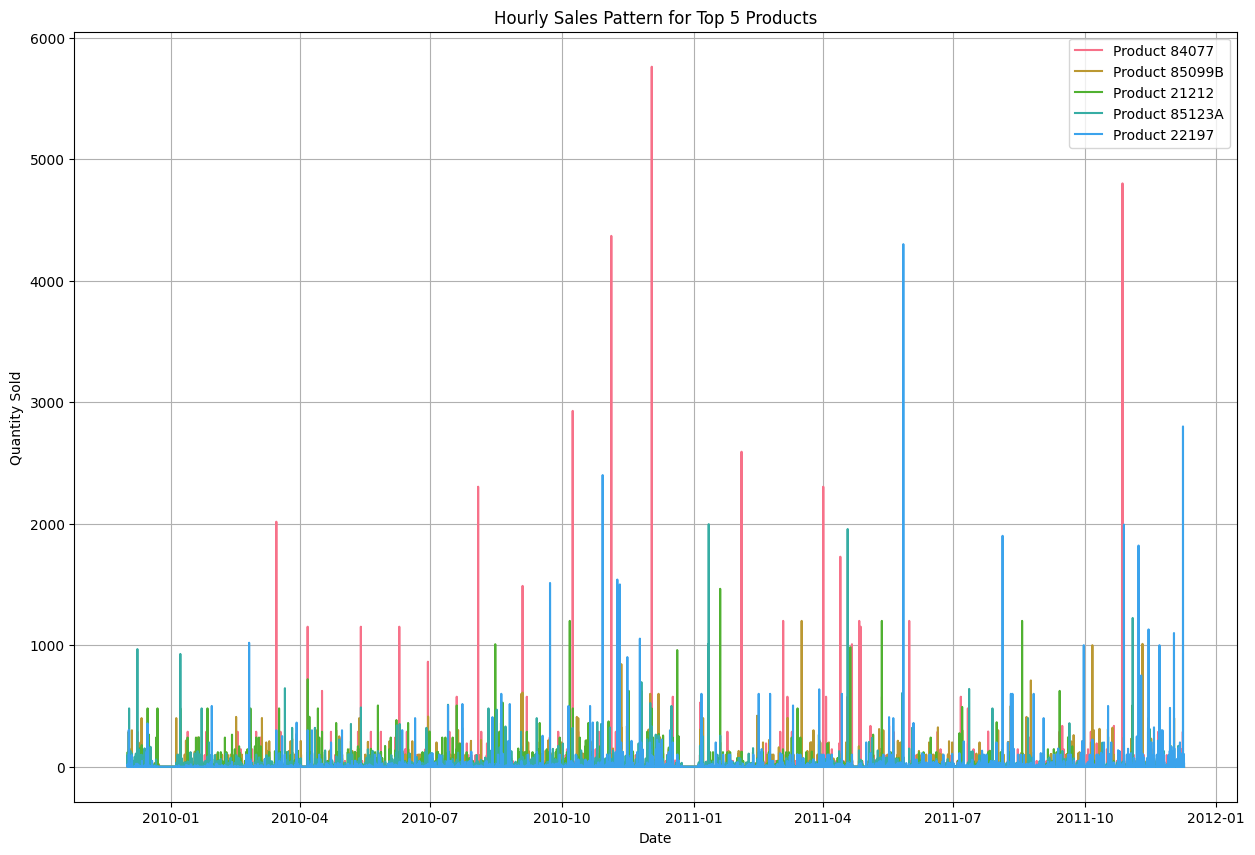

In [4]:
def create_time_series(df, product_id):
    # Filter data for specific product
    product_data = df[df['StockCode'] == product_id].copy()
    
    # Create hourly time series
    hourly_sales = product_data.groupby(
        pd.Grouper(key='InvoiceDate', freq='H')
    )['Quantity'].sum().fillna(0)
    
    return hourly_sales

# Get top 5 products by sales volume
top_products = df_cleaned.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).head()

# Plot time series for top products
plt.figure(figsize=(15, 10))
for product_id in top_products.index:
    sales_ts = create_time_series(df_cleaned, product_id)
    plt.plot(sales_ts.index, sales_ts.values, label=f'Product {product_id}')

plt.title('Hourly Sales Pattern for Top 5 Products')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.legend()
plt.grid(True)
plt.show()

## 4. Model Implementation

Now let's implement our ARIMA-based prediction model.

In [5]:
class SalesPredictionModel:
    def __init__(self, data):
        self.data = data
        self.models = {}
    
    def train_model(self, product_id, hours_lookback=168):
        # Get time series data
        sales_ts = create_time_series(self.data, product_id)
        if len(sales_ts) < 24:
            return None
            
        # Use auto_arima to find best parameters
        model = auto_arima(
            sales_ts,
            seasonal=True,
            m=24,
            suppress_warnings=True,
            error_action='ignore'
        )
        
        self.models[product_id] = model
        return model
    
    def predict(self, product_id, hours=24):
        if product_id not in self.models:
            model = self.train_model(product_id)
            if model is None:
                return None
                
        forecast = self.models[product_id].predict(n_periods=hours)
        return np.maximum(forecast, 0)  # Ensure non-negative predictions

# Initialize model
predictor = SalesPredictionModel(df_cleaned)

## 5. Visualization and Prediction

Let's visualize predictions for some products.

In [ ]:
def plot_prediction(product_id, hours=24):
    # Get historical data
    historical = create_time_series(df_cleaned, product_id)
    
    # Get prediction
    forecast = predictor.predict(product_id, hours)
    if forecast is None:
        print(f"Insufficient data for product {product_id}")
        return
    
    # Create future dates for forecast
    last_date = historical.index[-1]
    future_dates = pd.date_range(start=last_date, periods=hours+1, freq='H')[1:]
    
    # Plot
    plt.figure(figsize=(15, 6))
    
    # Plot historical data
    plt.plot(historical.index, historical.values, 
             label='Historical Sales', color='blue', alpha=0.7)
    
    # Plot forecast
    plt.plot(future_dates, forecast,
             label='Predicted Sales', color='red', linestyle='--')
    
    # Add confidence intervals (if available)
    plt.fill_between(future_dates,
                     forecast * 0.8,  # Lower bound
                     forecast * 1.2,  # Upper bound
                     color='red', alpha=0.2)
    
    plt.title(f'Sales Forecast for Product {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot predictions for top 3 products
for product_id in top_products.index[:3]:
    print(f"\nAnalyzing product {product_id}")
    plot_prediction(product_id)


Analyzing product 84077


## Model Evaluation

Let's evaluate our model's performance.

In [ ]:
def evaluate_model(product_id, test_size=24):
    # Get time series data
    sales_ts = create_time_series(df_cleaned, product_id)
    
    # Split into train and test
    train = sales_ts[:-test_size]
    test = sales_ts[-test_size:]
    
    # Train model on training data
    model = auto_arima(train, seasonal=True, m=24, suppress_warnings=True)
    
    # Make predictions
    predictions = model.predict(n_periods=test_size)
    
    # Calculate metrics
    mse = np.mean((test - predictions) ** 2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((test - predictions) / (test + 1))) * 100
    
    print(f"Evaluation metrics for product {product_id}:")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test.values, label='Actual')
    plt.plot(test.index, predictions, label='Predicted')
    plt.title(f'Actual vs Predicted Sales - Product {product_id}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate model for top product
top_product = top_products.index[0]
evaluate_model(top_product)